<a href="https://colab.research.google.com/github/mjpoulsen/ml-class/blob/main/bach_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bach Chorales

### The data file

https://raw.githubusercontent.com/zacharski/ml-class/master/data/bach.zip



Note that the data file is a compressed zip file. You will need to download it, unzip it, and then load it into a Pandas DataFrame. I wanted to give you a bit of practice in getting data in a variety of formats.

### Chords

A chord in music is a set of notes played together. For example, if you play the notes C, E, and G together they would form a C major chord. If you played A, C, and E together, they would form an A minor chord. Your task is to predict the chord based on the notes played and several other features. The `chord_label` column is what you are predicting. When you see a capital M in that column, as in C_M that stands for major (in this case C major) and a small m represents minor, so G_m is G minor.

### Bach Chorales

The dataset is of Johann Sebastian Bach's chorales and cantatas. Bach was very prolific and over 1,000 of his works still survive (some believe he composed over 10,000 pieces). Because of this, scholars have associated a identification number to each existing composition. This number is called BWV which stands for Bach-Werke-Verzeichnis. The `choral_ID` column in the dataset refers to this number. For example, the first row of the dataset and a choral_ID of 000106b_, which   stands for BWV106. If you did a Google search on this you would see it refers to the cantata: *Gottes Zeit ist die allerbeste Zeit*. The next column in the dataset is `event_number` which refers to a unique position in that composition. These two columns should not be used for training. Starting with the next column are the 12 notes of a Western Scale: C, C#, D, D#, E, F, F#, G, G#, A, A#, B. A *yes* in the column indicates that that note is currently being played during the specific event. So the first row of the data indicates that a C, F, and A are being played. The `bass` column represents what note is being played in the bass and the meter column represents the meter (how many beats per measure). 

### Optional Bonus XP
If you want to try to obtain additional xp you need to divide the data intro training and testing using the following

```
bach.set_index('choral_ID', inplace=True)
bFeatures = bach.drop('chord_label', axis=1)
bLabels = bach['chord_label']
from sklearn.model_selection import train_test_split
bach_train_features, bach_test_features, bach_train_labels, bach_test_labels = train_test_split(bFeatures, bLabels, test_size = 0.2, random_state=42)
```

this will give everyone the same test set (`random_state=42` is what enables this)

Bonus:

bonus | criteria
:---: | :---:
10 | better than .85 accuracy on `accuracy_score(bach_test_labels, predictions)`
20 | third best in class
25 | second best in class
30 | first in class

# Bach Chorales Project

This notebook will explore a Bach Chorales dataset. Then various Decision Tree models will predict chords based on notes, the bass note, and the meter.

Contents:

1.   Import Necessary Libraries
2.   Import the Data
3.   Data Analysis
4.   Data Visualization
5.   Cleaning Data
6.   Base Model
7.   XGBoost
8.   Conclusion



## 1) Import Necessary Libraries

### Runtime

Before we import libraries, let's ensure the runtime for this notebook is set to GPU. Without the GPU runtime, XGBoost will not run because the predictor is set to GPU.

If the following command produces a failure, do not proceed until the runtime has been set to GPU.

In [42]:
# Prove this notebook has GPU has the runtime type. If this fails, XGboost will not work.
!nvidia-smi

Sun Nov 13 13:55:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    29W /  70W |    860MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Import Libraries

This project will utilize various data anaylsis and machine learning Python libraries.



In [43]:
# Data analysis libraries
import pandas as pd

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn import tree
from xgboost import XGBClassifier

# Visualizing data
import seaborn as sns

## 2) Import the Data


### Upload Data

Upload `bach.csv` to the local drive. This csv file can be found by extracting it from https://raw.githubusercontent.com/zacharski/ml-class/master/data/bach.zip.

In [44]:
# Show bach.csv exists locally
!ls

bach.csv  sample_data


### Pandas

[Pandas](https://pandas.pydata.org/docs/reference/index.html) provides an easy way to read the contents of a csv file and instantiate an object, in this case a [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), that allows for easy manipulation of data. Plus, the machine learning libraries used in this notebook expect the data to be in a 2d array, which is how the contents are store in the DataFrame.

In [45]:
# Instantiate bach dataframe
bach = pd.read_csv('bach.csv')
bach

,choral_ID,event_number,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,bass,meter,chord_label
0,000106b_,1,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
1,000106b_,2,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,5,C_M
2,000106b_,3,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,2,C_M
3,000106b_,4,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3,F_M
4,000106b_,5,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,2,F_M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5660,015505b_,105,NO,NO,YES,NO,NO,NO,NO,YES,NO,NO,YES,NO,G,4,G_m
5661,015505b_,106,NO,NO,YES,NO,NO,NO,NO,YES,NO,YES,NO,NO,G,3,G_m
5662,015505b_,107,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,C,5,C_M
5663,015505b_,108,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,YES,NO,C,3,C_M


## 3) Data Analysis



### Possible Features

Before picking a model, the dataset's features need to be explored because the data should determine the type of learning, such as supervised vs. unsupervised.

In [46]:
# Print the possible features
print(bach.columns)

Index(['choral_ID', 'event_number', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G',
       'G#', 'A', 'A#', 'B', 'bass', 'meter', 'chord_label'],
      dtype='object')


The dataset should have the following:
```
'choral_ID', 'event_number', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'bass', 'meter', 'chord_label'
```

* The `choral_ID` indicates the Bach-Werke-Verzeichnis number. Bach's chorales and cantatas where published in the Bach-Werke-Verzeichnis catalog, and the editor, Wolfgang Schmieder, assigned a number to help group the works by their  genre. Given this value is more of a name rather than a feature, it should not be included in the training and test feature dataset.

* `event_number` this is the unique position within a composition. It will also not be of much use for learning and should not be included in the training and test feature dataset.

* The 12 notes of a Western Scale columns: C, C#, D, D#, E, F, F#, G, G#, A, A#, B. These columns represent whether the note is being played for the event. A `YES` means the note is played, whereas `NO` means the note is skipped (or not played).

* `bass` is the bass note played during the event.

* `meter` is the beats per minute for the event.

* `chord_label` is the chord played during the event. The chord is made from compositing the played notes, the bass note, and the meter. Therefore, this is the value the model will predict.

#### Taking a Look at the Data

The dataset contains `strings` and `ints`.

It's also complete, i.e. there are no `null` or equivalent value in the dataset. This is true becuase the count for each feature and label below is the same (5665). Had there been missing data, the values would need to be replaced with `np.NaN`, which could have been done during the DataFrame instantiation or during the Cleaning Data step.




In [47]:
#take a look at the training data
bach.describe(include="all")

,choral_ID,event_number,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,bass,meter,chord_label
count,5665,5665.000000,5665,5665,5665,5665,5665,5665,5665,5665,5665,5665,5665,5665,5665,5665.000000,5665
unique,60,NaN,2,2,2,2,2,2,2,2,2,2,2,2,16,NaN,102
top,002908ch,NaN,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,D,NaN,D_M
freq,207,NaN,3875,4711,3300,4956,3540,4381,4253,3523,5006,3290,4644,3874,689,NaN,503
mean,NaN,53.374404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.134863,NaN
std,NaN,37.268208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.109710,NaN
min,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
25%,NaN,24.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN
50%,NaN,48.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,NaN
75%,NaN,75.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN


#### Some Observations:

* The top `chord_label` is `D_M`.
* `meter` ranges from 1 to 5 with a mean of about 3.13.
* The top `bass` value is `D`.
* The top value for the 12 notes is `NO`. This should be expected because few notes are required to make a chord (two or more notes compose a chord). So each row should have more `NO`s than `YES`s.
* Of the 12 notes, `D#` and `G#` are used the least in the dataset (i.e. they have more `NO`s than the others).
* Of the 12 notes, `E` and `G` are used the most in the dataset (i.e. they have more `YES`s than the others).

#### Some Predictions:

* Subspacing features with a lower boundary of 70% will yield similar accuracies to no subspacing. This prediction is based on the `D#` and `G#` observation. `G#` is not used in 5006 out of the 5665 provided chords. When the data splits for training, there's a low chance chords with `G#` will be in the training set.
* When visualizing the data, `E` and `G` should have more `chord_label`s compared to the other notes.

## 4) Data Visualization

### Before Visualizing

* Given the dataset has 5665 entries, visualizing the data via a bar graph can look a bit messy. Therefore, a [list slicing](https://www.geeksforgeeks.org/python-list-slicing/) of 200 values will be used to generate more "readable" graphs. Given the dataset is ordered by `choral_ID`, list slicing will hopefully generate graphs with a variety of values because the first set of entries belong to the same composition and would not provide a valid representation of the data. It's worth mentioning that not all of the chords will be represented in the graphs, but the same chords will be represented in all of them. So the data should not be taken as absolute truth about the dataset.

* The `seaborn` bar plot requires at least `x` or `y` to be numeric. Because the `chord_label` is not numeric, other nonnumerical features will need to be encoded to a numeric value before visualizing.

* The graphs below are bar charts, and some bars have a thin black line. According to the [documentation](https://seaborn.pydata.org/generated/seaborn.barplot.html), that line represents the 95% confidence interval. No line, means `seaborn` is 95% or more confident the value is correct. On the other hand, the presence of the line shows the range of values until `seaborn`'s 95% confident or more. It's also worth noting that missing a confidence interval doesn't mean the value is correct because the data is sliced by 200. There are many sets of 199 values not represented in the graph.

In [48]:
sliceValue = 200

### `choral_ID` feature

This feature is nonnumerical and will require mapping/encoding before it can be compared to `chord_label`.

In [49]:
# Print the unqiue choral_IDs for the mapping/encoding step.
print(bach['choral_ID'].unique())

['000106b_' '000206b_' '000306b_' '000408b_' '000507b_' '000606b_'
 '000707b_' '000907b_' '001007b_' '001106b_' '001207b_' '001306b_'
 '001606b_' '001707b_' '001805b_' '001907ch' '002406bs' '002506b_'
 '002806b_' '002908ch' '003006b_' '003109b_' '003206b_' '003306b_'
 '003608b2' '003806b_' '003907b_' '003907bv' '004006b_' '004008b_'
 '005708b_' '012006b_' '012106b_' '012206b_' '012306b_' '012406b_'
 '012506b_' '012606b_' '012606bv' '012705b_' '012805b_' '013506b_'
 '013705ch' '013906b_' '014007b_' '014403b_' '014406b_' '014500ba'
 '014505b_' '014505bv' '014608b_' '014806b_' '014806bv' '015105b_'
 '015301b_' '015305b_' '015309b_' '015403b_' '015408b_' '015505b_']


The mapping/encoding will be simple. Each `choral_ID` will be assigned an integer.

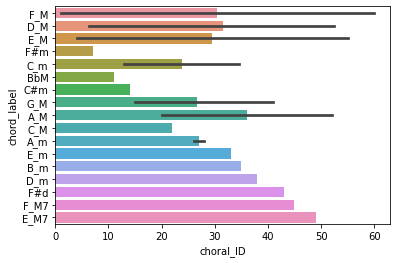

In [50]:
# Replace the strings values with the appropriate encoded value.
bach_encoded = bach.replace({'choral_ID': {'000106b_': 1, '000206b_': 2, '000306b_': 3, '000408b_': 4, 
                                             '000507b_': 5, '000606b_': 6, '000707b_': 7, '000907b_': 8, 
                                             '001007b_': 9, '001106b_': 10, '001207b_': 11, '001306b_': 12, 
                                             '001606b_': 13, '001707b_': 14, '001805b_': 15, '001907ch': 16, 
                                             '002406bs': 17, '002506b_': 18, '002806b_': 19, '002908ch': 20, 
                                             '003006b_': 21, '003109b_': 22, '003206b_': 23, '003306b_': 24, 
                                             '003608b2': 25, '003806b_': 26, '003907b_': 27, '003907bv': 28, 
                                             '004006b_': 29, '004008b_': 30, '005708b_': 31, '012006b_': 32, 
                                             '012106b_': 33, '012206b_': 34, '012306b_': 35, '012406b_': 36, 
                                             '012506b_': 37, '012606b_': 38, '012606bv': 39, '012705b_': 40, 
                                             '012805b_': 41, '013506b_': 42, '013705ch': 43, '013906b_': 44, 
                                             '014007b_': 45, '014403b_': 46, '014406b_': 47, '014500ba': 48, 
                                             '014505b_': 49, '014505bv': 50, '014608b_': 51, '014806b_': 52, 
                                             '014806bv': 53, '015105b_': 54, '015301b_': 55, '015305b_': 56, 
                                             '015309b_': 57, '015403b_': 58, '015408b_': 59, '015505b_': 60}})
# Plot the encoded data.
sns.barplot(x='choral_ID', y='chord_label', data=bach_encoded[::sliceValue])

10 out of the 17 chords appear in a specific composition. As previously mentioned, this should be not be taken as fact because the graph only shows a slice of the date, however, it's interesting to see that more than half of the chords present in the data set belong to a specific composition.

### `event_number` feature

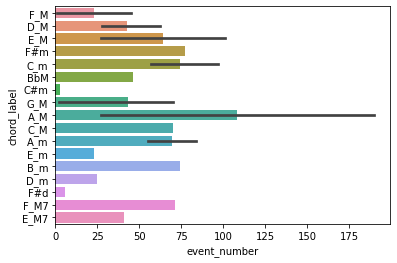

In [51]:
sns.barplot(x='event_number', y='chord_label', data=bach[::sliceValue])

There's not much to discern from this data. If anything, the data shows when a chord might be used within a composition.

### The Notes

Before visualizing the notes, it's worth mentioning that all notes will be visualized the same.

Because each column has only `YES` and `NO` values, they need to be encoded into `1` and `0` respectively.

Each graph is meant to show which chords the note is present in. Those chords with a confidence interval seem to indicate the note is present sometimes but not others. This leads me to wonder how important the `bass` and `meter` features are for determining the cord. Definitely not expected or predicted.

### `C` feature

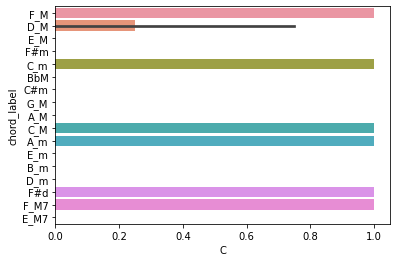

In [52]:
bach_encoded = bach.replace({'C': {'YES': 1, 'NO': 0}})
sns.barplot(x='C', y='chord_label', data=bach_encoded[::sliceValue])

### `C#` feature

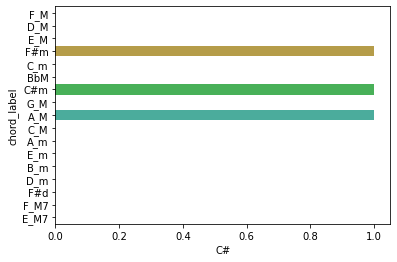

In [53]:
bach_encoded = bach.replace({'C#': {'YES': 1, 'NO': 0}})
sns.barplot(x='C#', y='chord_label', data=bach_encoded[::sliceValue])

### `D` feature

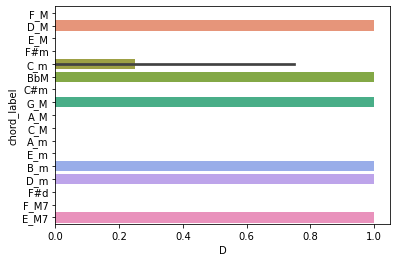

In [54]:
bach_encoded = bach.replace({'D': {'YES': 1, 'NO': 0}})
sns.barplot(x='D', y='chord_label', data=bach_encoded[::sliceValue])

### `D#` feature

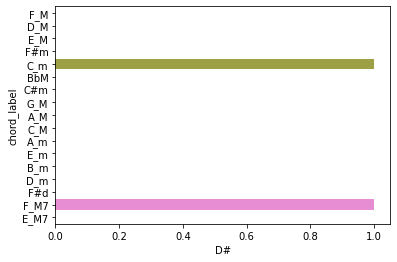

In [55]:
bach_encoded = bach.replace({'D#': {'YES': 1, 'NO': 0}})
sns.barplot(x='D#', y='chord_label', data=bach_encoded[::sliceValue])

### `E` feature

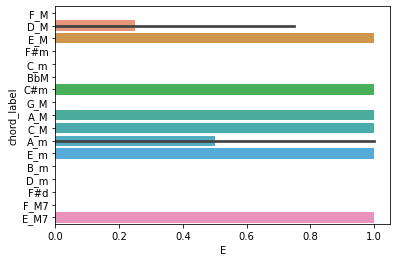

In [56]:
bach_encoded = bach.replace({'E': {'YES': 1, 'NO': 0}})
sns.barplot(x='E', y='chord_label', data=bach_encoded[::sliceValue])

### `F` feature

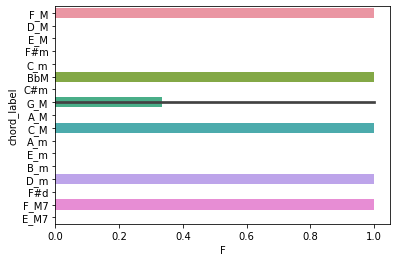

In [57]:
bach_encoded = bach.replace({'F': {'YES': 1, 'NO': 0}})
sns.barplot(x='F', y='chord_label', data=bach_encoded[::sliceValue])

### `F#` feature

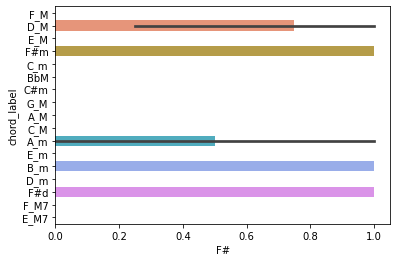

In [58]:
bach_encoded = bach.replace({'F#': {'YES': 1, 'NO': 0}})
sns.barplot(x='F#', y='chord_label', data=bach_encoded[::sliceValue])

### `G` feature

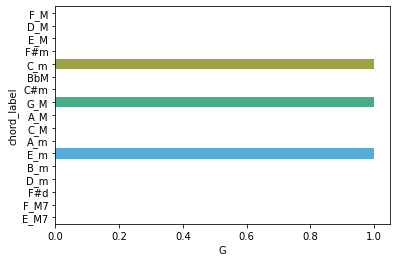

In [59]:
bach_encoded = bach.replace({'G': {'YES': 1, 'NO': 0}})
sns.barplot(x='G', y='chord_label', data=bach_encoded[::sliceValue])

### `G#` feature

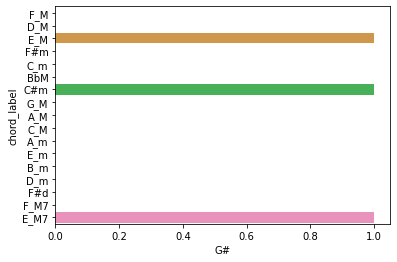

In [60]:
bach_encoded = bach.replace({'G#': {'YES': 1, 'NO': 0}})
sns.barplot(x='G#', y='chord_label', data=bach_encoded[::sliceValue])

### `A` feature

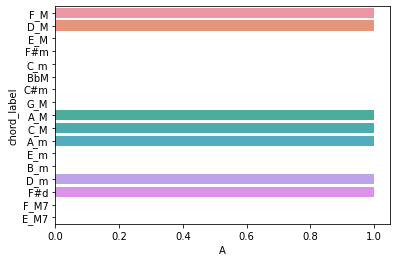

In [61]:
bach_encoded = bach.replace({'A': {'YES': 1, 'NO': 0}})
sns.barplot(x='A', y='chord_label', data=bach_encoded[::sliceValue])

### `A#` feature

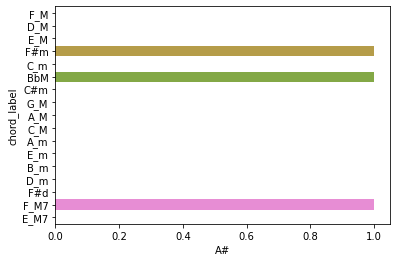

In [62]:
bach_encoded = bach.replace({'A#': {'YES': 1, 'NO': 0}})
sns.barplot(x='A#', y='chord_label', data=bach_encoded[::sliceValue])

### `B` feature

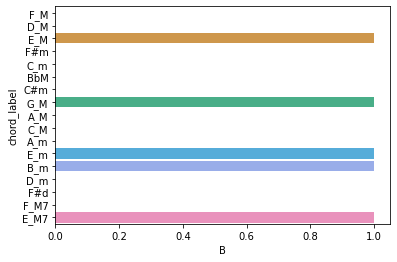

In [63]:
bach_encoded = bach.replace({'B': {'YES': 1, 'NO': 0}})
sns.barplot(x='B', y='chord_label', data=bach_encoded[::sliceValue])

### `bass` feature

Similar to the other nonnumerical features, the `bass` notes will need to be encoded before visualizing.

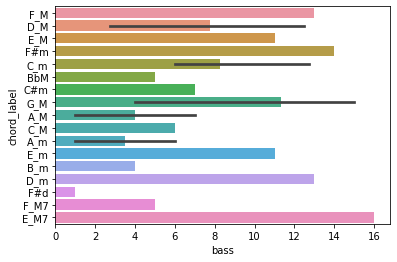

In [64]:
bach_encoded = bach.replace({'bass': {'A': 1, 'A#': 2, 'Ab': 3, 'B': 4, 'Bb': 5,
                                      'C': 6,  'C#': 7, 'D': 8, 'D#': 9, 'Db': 10,
                                      'E': 11, 'Eb': 12, 'F': 13, 'F#': 14, 
                                      'G': 15, 'G#': 16}})
sns.barplot(x='bass', y='chord_label', data=bach_encoded[::sliceValue])

12 out of the 17 chords have the same `bass` value, whereas the other 5 are paired with more than one value. 

Also, the sharp (`#`) chords seem to not have any confidence intervals.

### `meter` feature

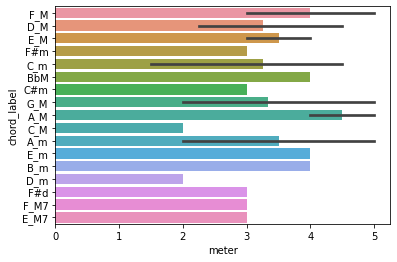

In [65]:
sns.barplot(x='meter', y='chord_label', data=bach[::sliceValue])

Similar to the `choral_ID`, there are 10 out of 17 chords with no confidence interval.

### Analysis of Observations

* Note sure if this is due to the slicing, but it seems that a decent amount of the chords do not vary in confidence in `meter` or `bass` values. Those properties should allow the learning model to need fewer choices to classify the chords. The confident chords are `F#m`, `BbM`, `C#m`, `C_M`, `E_m`, `B_m`, `D_m`, `F#d`, `F_M7`, and `E_M7`.
* The notes do not seem to have a pattern. For example, each of sharp notes appears in only 3 chords (they are not the same chords). Had the 3 chord subsets had a common property/feature (such as sharp and minor), then that would be interesting, but the subsets have chords with few overlapping qualities. The most overlap is a sharp chord, but `D#` doesn't appear in any of the sharp cords.
* As predicted, `D#` and `G#` appear in fewer chords. `D#` appears in 2 chords and `G#` appears in 3 chords, but to be fair `G` and the other sharp notes (expect `F#`) only appear in 3 chords.
  * The mean chord appearance for the note set is 4.92 (total appearance = 59, number of notes = 12, and 59 / 12 = 4.916666...).
* The prediction for `E` and `G` was half correct. Unfortunately, `G` only appeared in 3 chords, which is the second lowest frequency as discussed above. On the other hand, `E` appears in 8 chords, which is the highest frequency out of the other notes.

## 5) Cleaning Data

Before training a model to make predictions, standard practices indicate that cleaning up the data is important. This cleaning can range from removing or replacing values that models cannot interpet to simply splitting the data into features and labels.

### Features

These are the columns from the dataset that machine learning models will use to predict a `chord_label` value. Therefore, the first step to clean up the data is to remove the `chord_label`.

In [66]:
bach_features = bach.drop('chord_label', axis=1)
bach_features[:3]

,choral_ID,event_number,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,bass,meter
0,000106b_,1,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3
1,000106b_,2,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,5
2,000106b_,3,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,2


While removing the label column, the `choral_ID` and the `event_number` columns will also be dropped. They are removed from the dataset because a chord is not determined by the ID of an editor or the position in a composition. Instead, a chord is made of notes and a particular meter.

In [67]:
bach_features = bach_features.drop('choral_ID', axis=1)
bach_features = bach_features.drop('event_number', axis=1)
bach_features[:3]

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,bass,meter
0,YES,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,F,3
1,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,5
2,YES,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,E,2


### Labels

Labels are essentially the value a machine learning model should predict. It's effectively the answer. For the bach dataset, this is quite straightforward because the column `chord_label` is self-evident.

In [68]:
# Create bach label dataframe
bach_labels = bach['chord_label']

bach_labels[:3]

0    F_M
1    C_M
2    C_M
Name: chord_label, dtype: object

### Encoding

Unfortunately, machine learning models (that have been introduced in this class so far) cannot make predictions with features that are `strings`. This means that the data needs to be encoded.

As previously shown, the 12 notes values are `YES` and `NO`. Because these feature values are effectively a binary option, there are two possible encoding options: `1` and `0` or `True` and `False`. The `True` and `False` option was chosen because its more semantic with the origianl values, than `1` and `0`.

In [69]:
# Create a new dataframe for the encoded values
bach_feat_encoded = bach_features

# Replace YES and NO with True and False
bach_feat_encoded = bach_feat_encoded.replace({'C': {'YES': True, 'NO': False}})
bach_feat_encoded = bach_feat_encoded.replace({'C#': {'YES': True, 'NO': False}})
bach_feat_encoded = bach_feat_encoded.replace({'D': {'YES': True, 'NO': False}})
bach_feat_encoded = bach_feat_encoded.replace({'D#': {'YES': True, 'NO': False}})
bach_feat_encoded = bach_feat_encoded.replace({'E': {'YES': True, 'NO': False}})
bach_feat_encoded = bach_feat_encoded.replace({'F': {'YES': True, 'NO': False}})
bach_feat_encoded = bach_feat_encoded.replace({'F#': {'YES': True, 'NO': False}})
bach_feat_encoded = bach_feat_encoded.replace({'G': {'YES': True, 'NO': False}})
bach_feat_encoded = bach_feat_encoded.replace({'G#': {'YES': True, 'NO': False}})
bach_feat_encoded = bach_feat_encoded.replace({'A': {'YES': True, 'NO': False}})
bach_feat_encoded = bach_feat_encoded.replace({'A#': {'YES': True, 'NO': False}})
bach_feat_encoded = bach_feat_encoded.replace({'B': {'YES': True, 'NO': False}})

# Display the first 3 just to ensure the dataframe has been encoded properly
bach_feat_encoded[:3]

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,bass,meter
0,True,False,False,False,False,True,False,False,False,True,False,False,F,3
1,True,False,False,False,True,False,False,True,False,False,False,False,E,5
2,True,False,False,False,True,False,False,True,False,False,False,False,E,2


The `bass` notes will be encoding with a natural ordering (i.e. 1, 2, 3, 4, ...) because the possible value set for the `bass` feature is relatively small and the natural order set values will be close together (i.e. they do not require normalization). Had the value set been larger, a hashing function would probably be a better solution.

In [70]:
# Natural order encoding for the bass notes
bach_feat_encoded = bach_feat_encoded.replace({'bass': {'A': 1, 'A#': 2, 'Ab': 3,
                                                        'B': 4, 'Bb': 5, 'C': 6, 
                                                        'C#': 7, 'D': 8, 'D#': 9,
                                                        'Db': 10, 'E': 11, 
                                                        'Eb': 12, 'F': 13, 
                                                        'F#': 14, 'G': 15, 
                                                        'G#': 16}})

# Display the first 3 just to ensure the dataframe has been encoded properly
bach_feat_encoded[:3]

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,bass,meter
0,True,False,False,False,False,True,False,False,False,True,False,False,13,3
1,True,False,False,False,True,False,False,True,False,False,False,False,11,5
2,True,False,False,False,True,False,False,True,False,False,False,False,11,2


### Splitting the data

Standard practices of machine learning generally favor splitting the dataset into `training` and `test`. Their names are self-evident, but for clarity, the machine learning model will use the `training` set to learn (i.e. fit), and it will use the `test` set to make predictions.

Forunately, `SciKitLearn` has a useful tool for splitting the data: [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train_test_split#sklearn.model_selection.train_test_split)

In [71]:
# Split the dataframe
bach_train_features, bach_test_features, bach_train_labels, bach_test_labels = train_test_split(bach_feat_encoded, bach_labels, test_size = 0.2, random_state=42)
bach_train_features[:3]

,C,C#,D,D#,E,F,F#,G,G#,A,A#,B,bass,meter
4109,False,False,False,False,True,False,False,False,True,False,False,True,16,3
670,False,False,False,True,False,False,True,False,False,True,False,True,9,3
3493,False,False,False,True,False,False,False,False,True,False,False,True,16,5


## 6) Base Model

Before creating a XGBoost model, it's good practice to create a base model to have a baseline accuracy.

The model used for a base accuracy will be a Decision Tree Classifier. This classifier was chosen because it takes a supervisted learning approach. This is desired because supervised learning works best with classification, and a set of notes can be classified as a chord.

Another advantage of the Decision Tree is the hyperparameter `max_depth` can yield a variety of accuracies, which will be explored further in the XGBoost portion of this project.

In [72]:
# Create Decision Tree Classifier
bach_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Fit the decision tree
bach_clf.fit(bach_train_features, bach_train_labels)

# Predict the decision tree
bach_clf_predictions = bach_clf.predict(bach_test_features)

# Accuracy
accuracy_score(bach_test_labels, bach_clf_predictions)

0.6407766990291263

### Pasting and Random Patching

Now that a baseline accuracy score has been established, let's see the score of a Pasting classifier can achieve.

The classifier will be the same as the baseline, but this time there will be `20 estimators`.

In [73]:
# Create Decision Tree Classifier
bach_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Instantiate BagginClassifier with Random Patching
bach_pasting_clf = BaggingClassifier(bach_clf, n_estimators=20, bootstrap=False, n_jobs=-1)

# Fit the data
bach_pasting_clf.fit(bach_train_features, bach_train_labels)

# Predict
bach_pasting_predictions = bach_pasting_clf.predict(bach_test_features)

# Accuracy
accuracy_score(bach_test_labels, bach_pasting_predictions)

0.6407766990291263

This is the same accuracy as the baseline model. So 20 estimators does not increase the accuracy.

Next, let's see the score of a Pasting with Random Patching classifier.

This classifier is similar to the Pasting model but will also include the hyperparameters to achieve `70% samples and features`.

In [74]:
# Create Decision Tree Classifier
bach_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)

# Instantiate BagginClassifier with Random Patching
bach_random_patch_clf = BaggingClassifier(bach_clf, n_estimators=20, 
                                  max_samples=.7, max_features=.7, bootstrap=False, n_jobs=-1)

# Fit the data
bach_random_patch_clf.fit(bach_train_features, bach_train_labels)

# Predict
bach_random_patch_predictions = bach_random_patch_clf.predict(bach_test_features)

# Accuracy
accuracy_score(bach_test_labels, bach_random_patch_predictions)

0.676081200353045

### Prediction Analysis

The accuracy scores of Pasting and 70% Random Patching have a difference of 3%, which aligns with the prediction that some samples and features will not provide as much value in predicting chords.

## 7) XGBoost

According to the [XGBoost documentation](https://xgboost.readthedocs.io/en/stable/), it is an optimized distributed gradient boosting library. Graident boosting is a maching learning technique used for various tasks, such as classification, by forming a model based on weaker prediction models, usually a descision tree.

(This is another reason why the chosen base model was a decision tree.)

### Base XGBoost Model

Before the XGBoost model is instantiated, a few parameters are defined. Taking a look at the `params` object, the number of estimators is the same from the previous Pasting classifiers, and the predictor will use the GPU.

By setting the number of estimators to the same as the Pasting classifiers, their scores can be compared without qualifying either as having an advantage.

The GPU predictor was choosen because XGBoost implements gradient descent, and GPUs can perform those calculations quicker than a CPU.

In [75]:
# Define the params for XGBClassifier as GPU and estimators
params = { 'n_estimators': 20, 'tree_method':'gpu_hist', 'predictor':'gpu_predictor' }

model = XGBClassifier(**params)
model

XGBClassifier(n_estimators=20, predictor='gpu_predictor',
              tree_method='gpu_hist')

Fit the data (i.e. train the model).

In [76]:
model.fit(bach_train_features, bach_train_labels)

XGBClassifier(n_estimators=20, objective='multi:softprob',
              predictor='gpu_predictor', tree_method='gpu_hist')

Evaluate the model.

In [77]:
base_boost_predictions = model.predict(bach_test_features)
base_boost_score = accuracy_score(bach_test_labels, base_boost_predictions)
base_boost_score

0.703442188879082

That's a decent improvement in accuracy of about 6% from the baseline and Pasting models, but only about 3% improvement over subspacing.

### Searching for best params

Now that a baseline accuracy has been established for the XGBoost model, let's try to improve that score by finding the best hyperparameters from a set of values.

In [78]:
# Define the params for XGBClassifier as GPU
params = { 'tree_method':'gpu_hist', 'predictor':'gpu_predictor' }

model = XGBClassifier(**params)
model

XGBClassifier(predictor='gpu_predictor', tree_method='gpu_hist')

Define the parameters for XGBoost to test. Some of the values represented in the parameter set are the same hyperparameters as the previous classifiers. They were included in case those are the best parameters.

In [79]:
param_grid = { 'n_estimators': [20, 45, 70, 95], 'max_depth': [6, 9, 12, 15] }

Create a Random Search model with the XGBoost model.

There are 16 combinations and 5 fold cross validation. That will make 80 fits with an average of 42 classifiers.

The algorithm will select 5 combinations of hyperparameters at random.

In [80]:
param_comb = 5
folds = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=param_comb, n_jobs=-1, 
                                   cv=skf.split(bach_train_features, bach_train_labels), verbose=3)

Fit the training data by searching for best params.

In [81]:
%%time 
grid_result = random_search.fit(bach_train_features, bach_train_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 21.5 s, sys: 366 ms, total: 21.9 s
Wall time: 10min 16s


Display the best params.

In [82]:
random_search.best_params_

{'n_estimators': 45, 'max_depth': 9}

Display the accuracy

In [83]:
predictions = random_search.best_estimator_.predict(bach_test_features)
accuracy_score(bach_test_labels, predictions)

0.736098852603707

With the best parameters from the provided set, the score improved by 3.5%.



## 8) Conclusion

### Summary of Scores

| Classifier      | Score |
| ----------- | ----------- |
| Decision Tree Baseline Model      | 0.6407766990291263       |
| Pasting Model   | 0.6407766990291263        |
| Random Patching Model   | 0.6716681376875552        |
| XGBoost Model   | 0.703442188879082        |
| XGBoost Best Param Model   | 0.736098852603707        |

### Best Hyperparameters

The best hyperparameters found by the XGBoost model are `65` estimators and a max depth of `9` for the Decision Tree.

So it seems that more estimators will increase the score but the max depth asymptotes around `9`.